# Database comparisons
The purpose of this notebook is to evaluate classification accuracy between different reference databases. Select mock community sequences are taxonomically classified using two or more different reference databases, e.g., Greengenes 13_8 [trimmed to 250 nt](./generate-tax-assignments.ipynb) and the same database [trimmed to 150 nt](./generate-tax-assignments-trimmed-dbs.ipynb). [This notebook](./generate-tax-assignments-trimmed-dbs.ipynb) can also be modified to provide taxonomic classification with any number of desired reference databases/versions. Limit the analysis to only a few mock communities and method/parameter combinations; the goal here is to compare the databases, not the methods.

In the example below, we compare RDP classifications of a single 16S rRNA dataset (mock-3) and a single fungal ITS dataset (mock-9) using three different reference databases: reference sequences that are full length (e.g., full 16S rRNA gene), trimmed to 250 nt (approximately full V4 gene), or trimmed to 150 nt or 100 nt (length of sequence read).

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [64]:
%matplotlib inline

from os.path import join, expandvars
import pandas as pd
from IPython.display import display

from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,)
from tax_credit.framework_functions import (per_level_kruskal_wallis)
from tax_credit.eval_framework import (method_by_dataset_a1,
                                       method_by_dataset_a2,
                                       evaluate_results,
                                       parameter_comparisons,
                                       method_by_dataset)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [3]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## short-read-tax-assignment repository. 
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")

## precomputed_results_dir is the directory containing taxonomy assignment
## results to compare. Defaults to the precomputed results in tax-credit
precomputed_results_dir = join(project_dir, "data/precomputed-results/")

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(precomputed_results_dir, "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is just the precomputed 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [precomputed_results_dir]

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

Find mock community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

In [36]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                taxonomy_level_range=range(2,7), 
                                min_count=1,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                force=False)

In [37]:
mock_results

Dataset  Level        SampleID         Reference  Method Parameters  \
0       mock-1      2  MockHiSeq.even      gg_13_8_otus     rdp        0.0   
1       mock-1      3  MockHiSeq.even      gg_13_8_otus     rdp        0.0   
2       mock-1      4  MockHiSeq.even      gg_13_8_otus     rdp        0.0   
3       mock-1      5  MockHiSeq.even      gg_13_8_otus     rdp        0.0   
4       mock-1      6  MockHiSeq.even      gg_13_8_otus     rdp        0.0   
325    mock-10      2          Mock.1  unite_20.11.2016     rdp        0.0   
326    mock-10      2          Mock.2  unite_20.11.2016     rdp        0.0   
327    mock-10      2          Mock.3  unite_20.11.2016     rdp        0.0   
328    mock-10      3          Mock.1  unite_20.11.2016     rdp        0.0   
329    mock-10      3          Mock.2  unite_20.11.2016     rdp        0.0   
330    mock-10      3          Mock.3  unite_20.11.2016     rdp        0.0   
331    mock-10      4          Mock.1  unite_20.11.2016     rdp        0.0   
332    mock-10      4          Mock.2  unite_20.11.2016     rdp        0.0   
333    mock-10      4          Mock.3  unite_20.11.2016     rdp        0.0   
334    mock-10      5          Mock.1  unite_20.11.2016     rdp        0.0   
335    mock-10      5          Mock.2  unite_20.11.2016     rdp        0.0   
336    mock-10      5          Mock.3  unite_20.11.2016     rdp        0.0   
337    mock-10      6          Mock.1  unite_20.11.2016     rdp        0.0   
338    mock-10      6          Mock.2  unite_20.11.2016     rdp        0.0   
339    mock-10      6          Mock.3  unite_20.11.2016     rdp        0.0   
1300   mock-12      2       Extreme.1      gg_13_8_otus     rdp        0.0   
1301   mock-12      3       Extreme.1      gg_13_8_otus     rdp        0.0   
1302   mock-12      4       Extreme.1      gg_13_8_otus     rdp        0.0   
1303   mock-12      5       Extreme.1      gg_13_8_otus     rdp        0.0   
1304   mock-12      6       Extreme.1      gg_13_8_otus     rdp        0.0   
1625    mock-2      2  MockMiSeq.even      gg_13_8_otus     rdp        0.0   
1626    mock-2      3  MockMiSeq.even      gg_13_8_otus     rdp        0.0   
1627    mock-2      4  MockMiSeq.even      gg_13_8_otus     rdp        0.0   
1628    mock-2      5  MockMiSeq.even      gg_13_8_otus     rdp        0.0   
1629    mock-2      6  MockMiSeq.even      gg_13_8_otus     rdp        0.0   
...        ...    ...             ...               ...     ...        ...   
9200    mock-8      2           Even1      gg_13_8_otus  uclust  1.0:0.9:5   
9201    mock-8      2           Even2      gg_13_8_otus  uclust  1.0:0.9:5   
9202    mock-8      2           Even3      gg_13_8_otus  uclust  1.0:0.9:5   
9203    mock-8      3           Even1      gg_13_8_otus  uclust  1.0:0.9:5   
9204    mock-8      3           Even2      gg_13_8_otus  uclust  1.0:0.9:5   
9205    mock-8      3           Even3      gg_13_8_otus  uclust  1.0:0.9:5   
9206    mock-8      4           Even1      gg_13_8_otus  uclust  1.0:0.9:5   
9207    mock-8      4           Even2      gg_13_8_otus  uclust  1.0:0.9:5   
9208    mock-8      4           Even3      gg_13_8_otus  uclust  1.0:0.9:5   
9209    mock-8      5           Even1      gg_13_8_otus  uclust  1.0:0.9:5   
9210    mock-8      5           Even2      gg_13_8_otus  uclust  1.0:0.9:5   
9211    mock-8      5           Even3      gg_13_8_otus  uclust  1.0:0.9:5   
9212    mock-8      6           Even1      gg_13_8_otus  uclust  1.0:0.9:5   
9213    mock-8      6           Even2      gg_13_8_otus  uclust  1.0:0.9:5   
9214    mock-8      6           Even3      gg_13_8_otus  uclust  1.0:0.9:5   
10175   mock-9      2          Mock.1  unite_20.11.2016  uclust  1.0:0.9:5   
10176   mock-9      2          Mock.2  unite_20.11.2016  uclust  1.0:0.9:5   
10177   mock-9      2          Mock.3  unite_20.11.2016  uclust  1.0:0.9:5   
10178   mock-9      3          Mock.1  unite_20.11.2016  uclust  1.0:0.9:5   
10179   mock-9      3        

Restrict analyses to a set of datasets used for purpose of reference database comparisons.

In [38]:
mock_results = mock_results[mock_results['Method'] == 'rdp']
mock_results = mock_results[mock_results['Dataset'].isin(['mock-3', 'mock-9'])]

Evalution 1: Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. 

This is a qualitative evaluation, effectively telling us about the ability of the different methods to report the taxa that are present in each sample. These metrics are not concerned with the abundance of the different taxa.

As a first step, we will evaluate how accuracy metrics perform at each taxonomic level for each method within each reference dataset type.

In [43]:
color_pallette = {'gg_13_8_otus':'seagreen', 'gg_13_8_otus_trim150':'blue', 'gg_13_8_otus_full16S':'orange',
                  'unite_20.11.2016':'seagreen', 'unite_20.11.2016_trim100':'blue', 'unite_20.11.2016_fullITS':'orange', 'unite_20.11.2016_trim150':'red'}

y_vars = ["Precision", "Recall", "F-measure", "Pearson r", "Spearman r"]

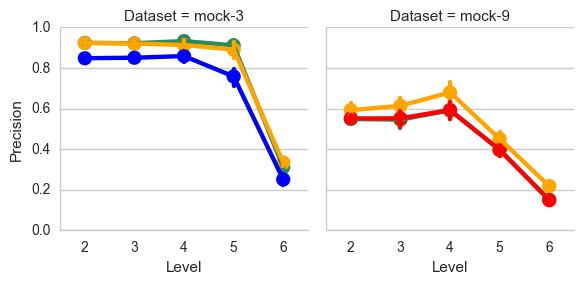

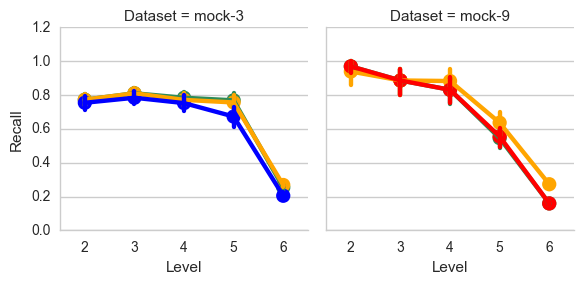

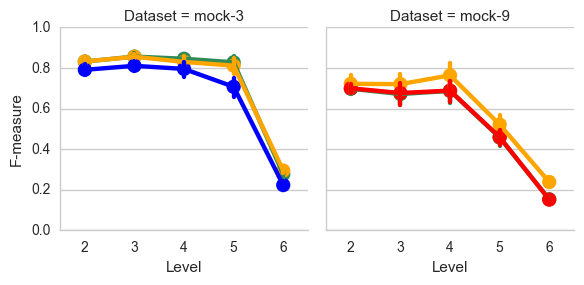

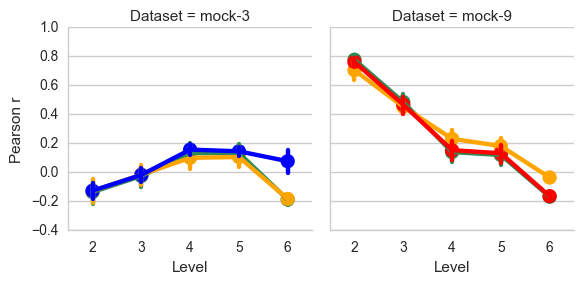

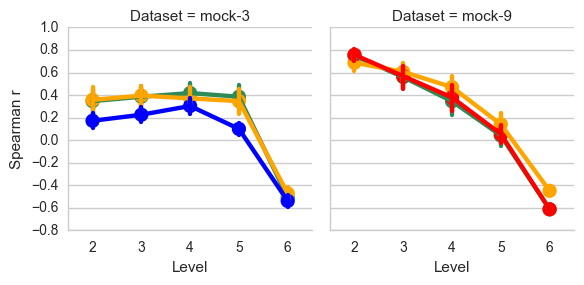

In [44]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Dataset", color_by="Reference",
                          color_pallette=color_pallette)

Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [63]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Reference', 
                                  dataset_col='Method', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset    Variable             2             3             4             5  \
0     rdp   Precision  1.704889e-36  4.828530e-35  2.708966e-31  6.742947e-34   
1     rdp      Recall  1.389812e-26  2.021416e-12  2.254184e-06  1.287713e-11   
2     rdp   F-measure  2.007426e-17  4.309077e-19  7.129689e-11  1.365639e-27   
3     rdp   Pearson r  6.742947e-34  3.214174e-28  1.543792e-01  7.632588e-01   
4     rdp  Spearman r  7.046412e-18  2.303509e-09  1.418035e-01  2.405902e-05   

              6  
0  1.365639e-27  
1  1.033693e-18  
2  2.396273e-22  
3  5.675735e-13  
4  7.962887e-04

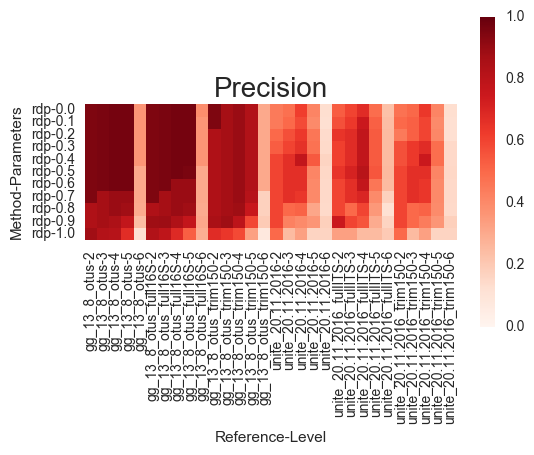

In [65]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

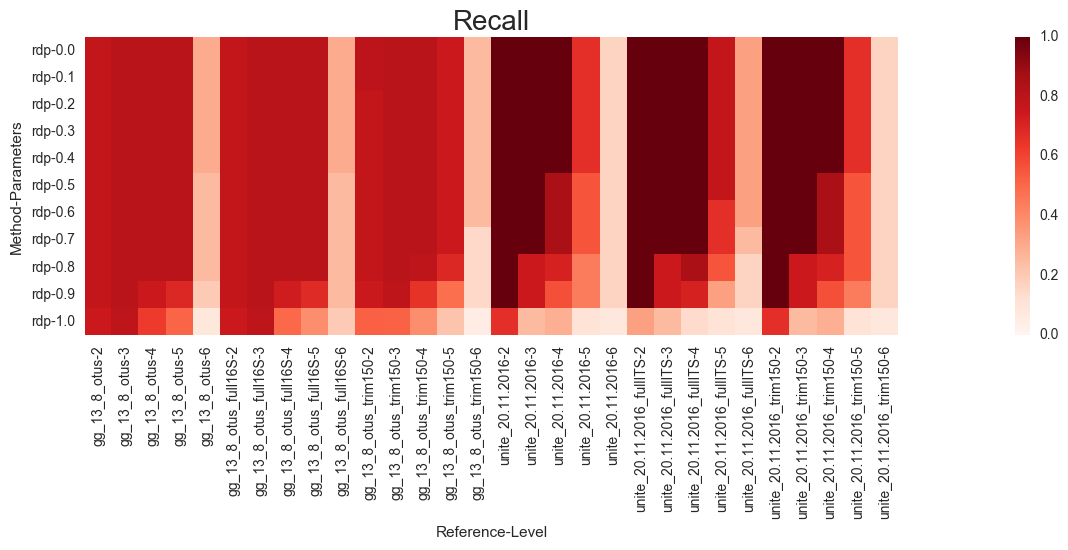

In [47]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

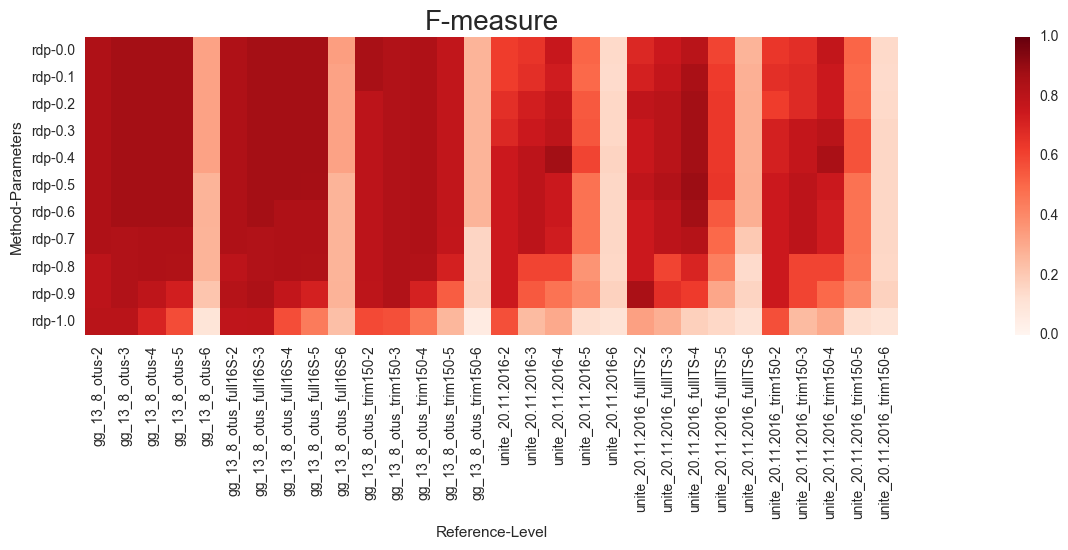

In [48]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

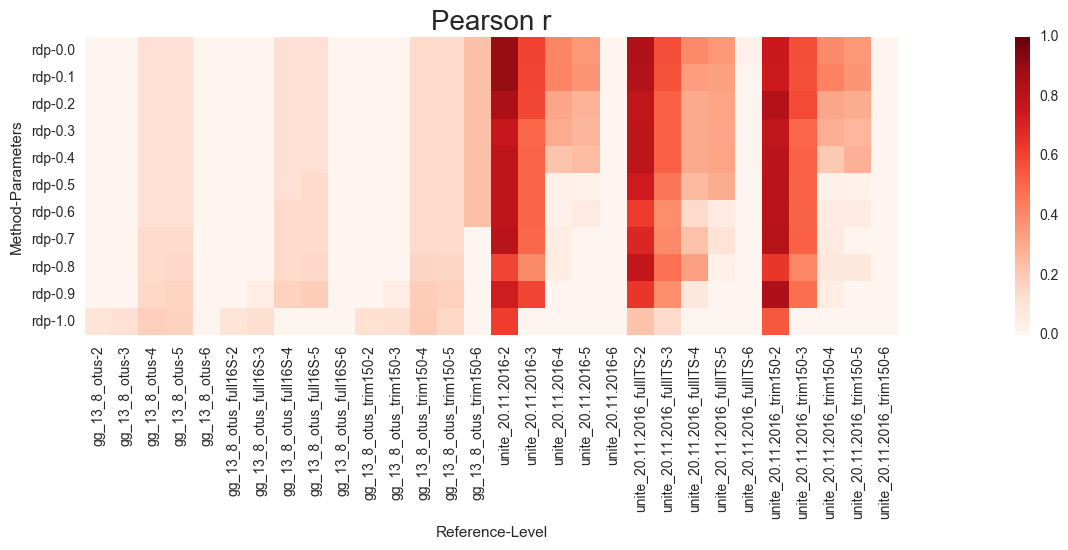

In [49]:
heatmap_from_data_frame(mock_results, metric="Pearson r", rows=["Method", "Parameters"], cols=["Reference", "Level"])

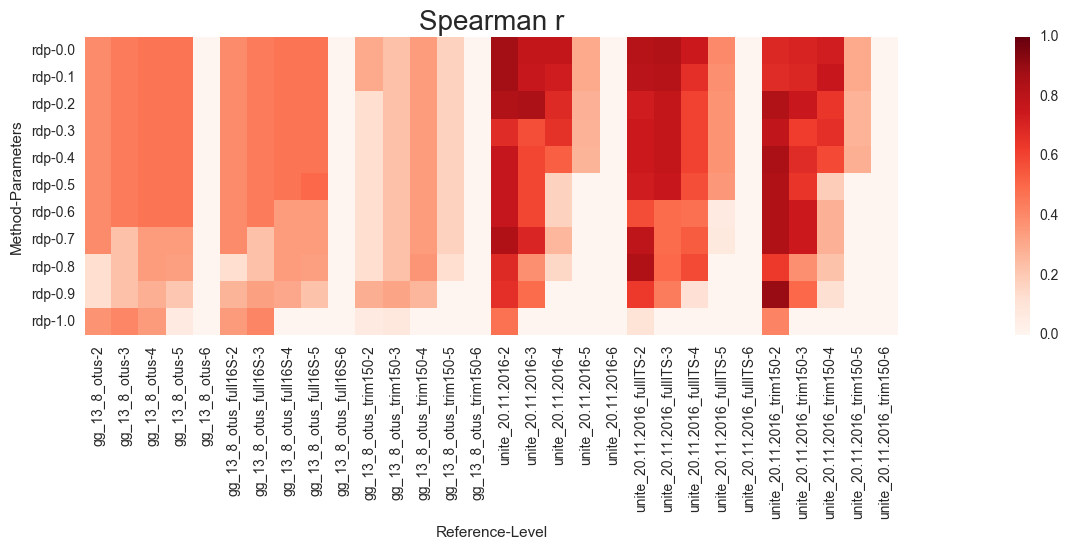

In [50]:
heatmap_from_data_frame(mock_results, metric="Spearman r", rows=["Method", "Parameters"], cols=["Reference", "Level"])

Now we will focus on results at genus level (for species level, change to level 6)

In [51]:
mock_results_6 = mock_results[mock_results['Level'] == 5]

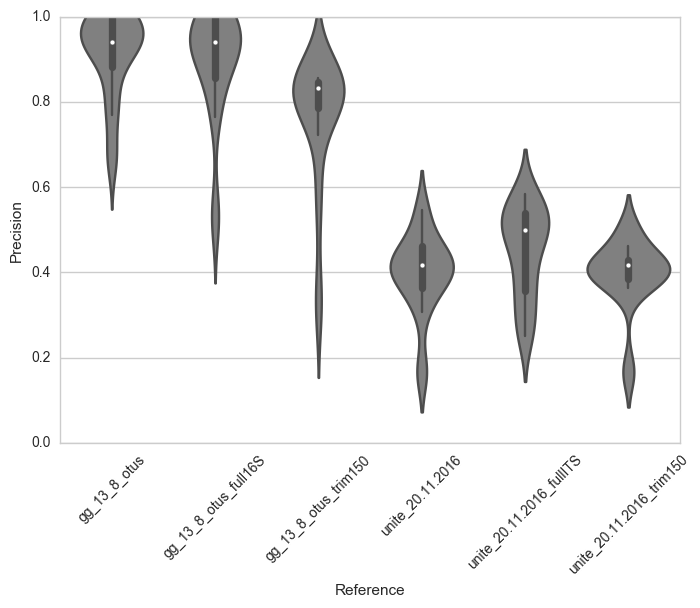

In [52]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="Precision")

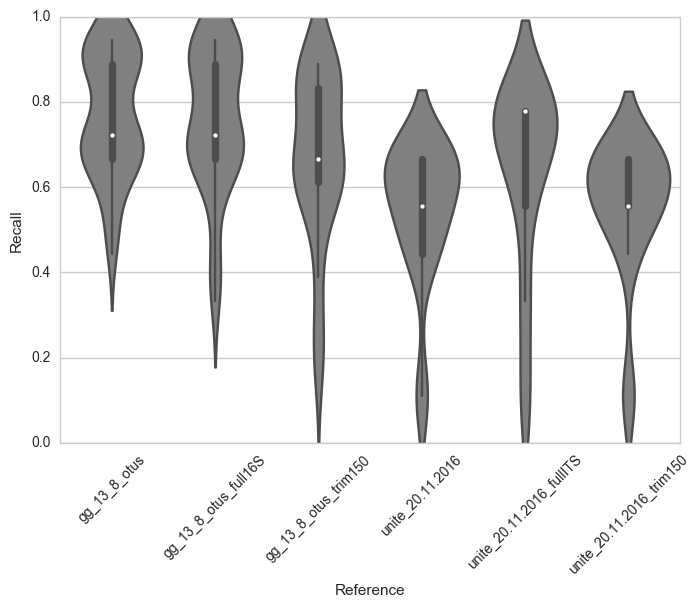

In [53]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="Recall")

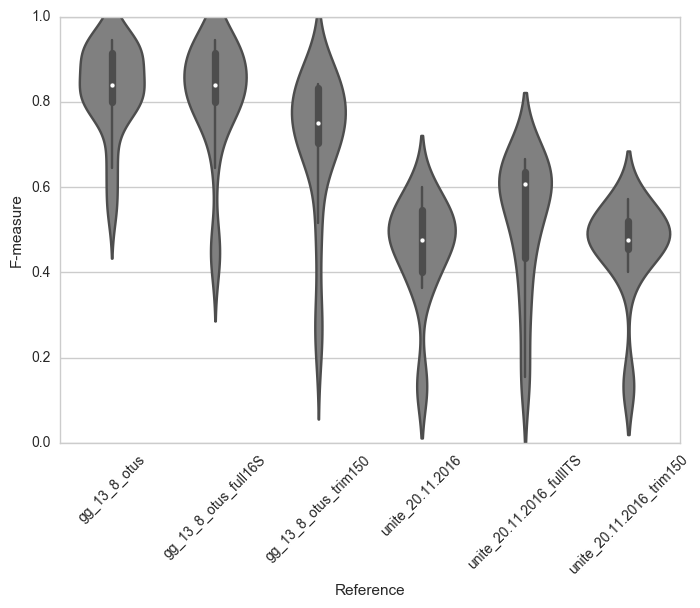

In [54]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="F-measure")

In [55]:
for dataset in mock_results['Reference'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(mock_results[mock_results["Level"] == level],
                                        group_by = 'Reference',
                                        dataset=dataset, sort_field="F-measure",
                                        display_fields=("Method", "Parameters", "Precision", "Recall", "F-measure"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

gg_13_8_otus level 4


Method Parameters  Precision    Recall  F-measure
2079    rdp        0.6   0.944444  0.944444   0.944444

gg_13_8_otus level 5


Method Parameters  Precision    Recall  F-measure
2083    rdp        0.6   0.944444  0.944444   0.944444

gg_13_8_otus level 6


Method Parameters  Precision  Recall  F-measure
1968    rdp        0.0   0.461538     0.3   0.363636

gg_13_8_otus_full16S level 4


Method Parameters  Precision    Recall  F-measure
3279    rdp        0.1   0.944444  0.944444   0.944444

gg_13_8_otus_full16S level 5


Method Parameters  Precision    Recall  F-measure
3283    rdp        0.1   0.944444  0.944444   0.944444

gg_13_8_otus_full16S level 6


Method Parameters  Precision  Recall  F-measure
3268    rdp        0.0        0.5     0.3      0.375

gg_13_8_otus_trim150 level 4


Method Parameters  Precision    Recall  F-measure
3619    rdp        0.7       0.85  0.944444   0.894737

gg_13_8_otus_trim150 level 5


Method Parameters  Precision    Recall  F-measure
3543    rdp        0.3        0.8  0.888889   0.842105

gg_13_8_otus_trim150 level 6


Method Parameters  Precision  Recall  F-measure
3588    rdp        0.5   0.384615    0.25    0.30303

unite_20.11.2016 level 4


Method Parameters  Precision  Recall  F-measure
9283    rdp        0.4   0.777778     1.0      0.875

unite_20.11.2016 level 5


Method Parameters  Precision    Recall  F-measure
9286    rdp        0.4   0.545455  0.666667        0.6

unite_20.11.2016 level 6


Method Parameters  Precision    Recall  F-measure
9364    rdp        0.9   0.181818  0.166667   0.173913

unite_20.11.2016_fullITS level 4


Method Parameters  Precision  Recall  F-measure
10228    rdp        0.2      0.875     1.0   0.933333

unite_20.11.2016_fullITS level 5


Method Parameters  Precision    Recall  F-measure
10276    rdp        0.5   0.583333  0.777778   0.666667

unite_20.11.2016_fullITS level 6


Method Parameters  Precision    Recall  F-measure
10264    rdp        0.4   0.266667  0.333333   0.296296

unite_20.11.2016_trim150 level 4


Method Parameters  Precision  Recall  F-measure
10421    rdp        0.4   0.777778     1.0      0.875

unite_20.11.2016_trim150 level 5


Method Parameters  Precision    Recall  F-measure
10409    rdp        0.3        0.5  0.666667   0.571429

unite_20.11.2016_trim150 level 6


Method Parameters  Precision    Recall  F-measure
10504    rdp        0.9   0.181818  0.166667   0.173913

Evaluation 2: Compute and summarize correlations between observed and known mock community structure
----------------------------------------------------------------------------------------------------

In this evaluation, we compute and summarize the correlation between each result (pre-computed and query) and the known composition of the mock communities. We then summarize the results in two ways: first with a series of boxplots of correlation coefficients by method; and second with a table of the top methods based on their Pearson correlation coefficient. 

This is a quantitative evaluation, which tells us about the ability of the different methods to report the taxa that are present in each sample and accurately assess their abundance. Because many factors can affect the observed abundance of taxa beyond the accuracy of the taxonomic assigner (e.g., primer bias), the correlation coefficients are frequently low, but we expect that their relative values are informative in understanding which taxonomic assigners are more correct than others.

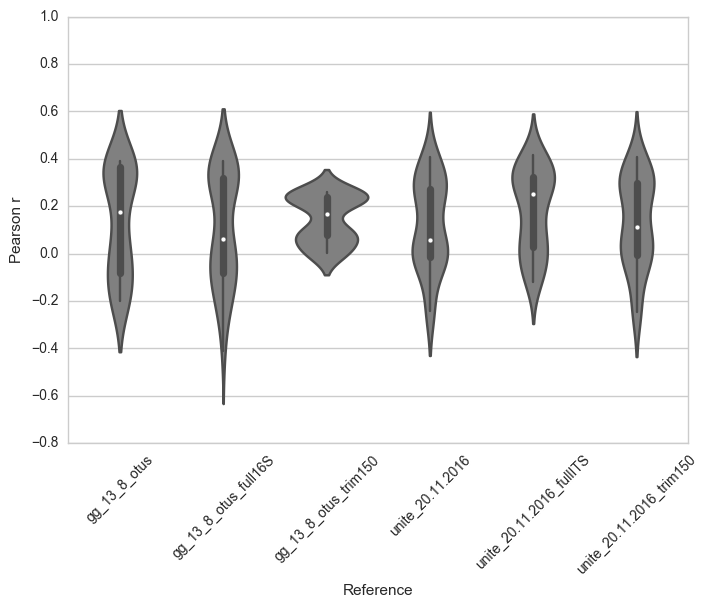

In [56]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="Pearson r", y_min=None)

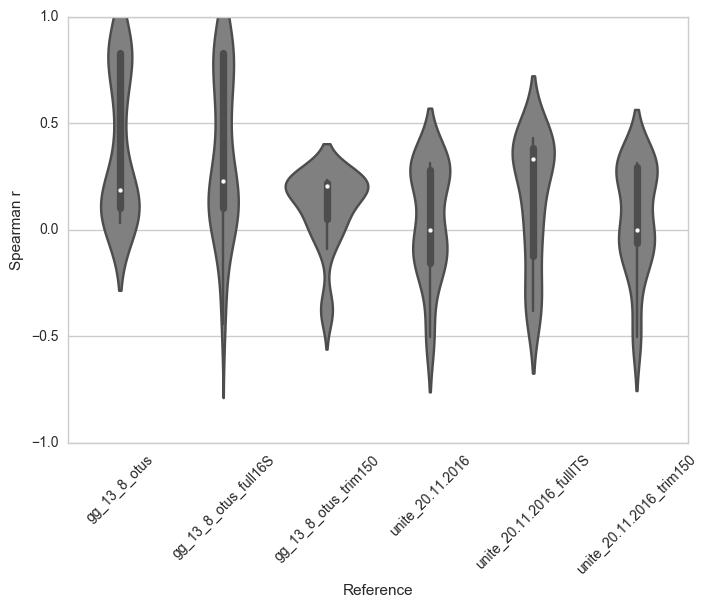

In [57]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="Spearman r", y_min=None)

In [58]:
for dataset in mock_results['Reference'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(mock_results[mock_results["Level"] == level],
                                        group_by = 'Reference',
                                        dataset=dataset, sort_field="Pearson r",
                                        display_fields=("Method", "Parameters", "Pearson r", "Spearman r"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

gg_13_8_otus level 4


Method Parameters  Pearson r  Spearman r
2060    rdp        0.5   0.391337    0.834849

gg_13_8_otus level 5


Method Parameters  Pearson r  Spearman r
2064    rdp        0.5   0.391337    0.834849

gg_13_8_otus level 6


Method Parameters  Pearson r  Spearman r
2089    rdp        0.6  -0.048563    -0.35789

gg_13_8_otus_full16S level 4


Method Parameters  Pearson r  Spearman r
3360    rdp        0.5   0.391337    0.834849

gg_13_8_otus_full16S level 5


Method Parameters  Pearson r  Spearman r
3304    rdp        0.2   0.391337    0.834849

gg_13_8_otus_full16S level 6


Method Parameters  Pearson r  Spearman r
3268    rdp        0.0  -0.021617   -0.100261

gg_13_8_otus_trim150 level 4


Method Parameters  Pearson r  Spearman r
3660    rdp        0.9    0.30969    0.445759

gg_13_8_otus_trim150 level 5


Method Parameters  Pearson r  Spearman r
3685    rdp        1.0   0.261684   -0.360909

gg_13_8_otus_trim150 level 6


Method Parameters  Pearson r  Spearman r
3529    rdp        0.2   0.446253    -0.30641

unite_20.11.2016 level 4


Method Parameters  Pearson r  Spearman r
9222    rdp        0.0   0.504201    0.800656

unite_20.11.2016 level 5


Method Parameters  Pearson r  Spearman r
9225    rdp        0.0    0.40919    0.303562

unite_20.11.2016 level 6


Method Parameters  Pearson r  Spearman r
9228    rdp        0.0  -0.013854   -0.552881

unite_20.11.2016_fullITS level 4


Method Parameters  Pearson r  Spearman r
10197    rdp        0.0   0.509576     0.78437

unite_20.11.2016_fullITS level 5


Method Parameters  Pearson r  Spearman r
10200    rdp        0.0    0.41626     0.42948

unite_20.11.2016_fullITS level 6


Method Parameters  Pearson r  Spearman r
10203    rdp        0.0    0.06691   -0.357226

unite_20.11.2016_trim150 level 4


Method Parameters  Pearson r  Spearman r
10377    rdp        0.1    0.49903    0.761554

unite_20.11.2016_trim150 level 5


Method Parameters  Pearson r  Spearman r
10365    rdp        0.0    0.40919    0.303562

unite_20.11.2016_trim150 level 6


Method Parameters  Pearson r  Spearman r
10368    rdp        0.0  -0.013854   -0.552881